In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 
matplotlib.rc('text', usetex = True)

In [2]:
pd.DataFrame()

""


- use a kernel function, so generate that it would fall off
- apwalsh/EDAS2018_Davies

In [3]:
import numpy as np
def kernel(t1, t2, p):
    cov = p[0]**2 * np.exp(-0.5 * np.subtract.outer(t1, t2)**2 / p[1]**2)
    return cov

/home/oliver/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


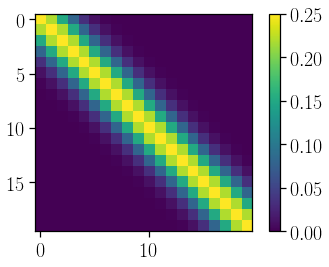

In [4]:
npts = 20

np.random.seed(24601)

x = np.arange(npts)
theta = [.5, 2.]
cov = kernel(x, x, theta)

plt.imshow(cov)
plt.colorbar()
plt.show()

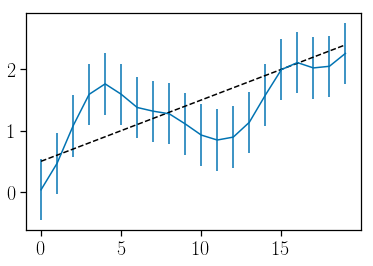

In [5]:
a, b = .1, .5
trend = a*x + b
np.random.seed(24601)
y = np.random.multivariate_normal(trend, cov)
plt.errorbar(range(npts), y, yerr=theta[0])
plt.plot(x,trend,c='k', linestyle='--')
plt.show()

### Model without covariance

In [8]:
import pystan
overwrite=False
nocov = '''
data {
    int<lower = 0> N;
    vector[N] y;
    vector[N] x;
    real err;
}
parameters {
    real a;
    real b;
}
model {
    a ~ normal(0., 1.);
    b ~ normal(0., 1.);
    y ~ normal(a*x + b, err);
}
'''
import os
import pickle
model_path = 'nocov.pkl'
if overwrite:
    sm = pystan.StanModel(model_code = nocov)
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = nocov)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e7efe6768a1757265abc6e659be7476c NOW.


In [9]:
dat = {'N':len(y),
      'y' : y,
      'x' : x,
      'err' : theta[0]}
fit = sm.sampling(data=dat, iter=10000, chains=2)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


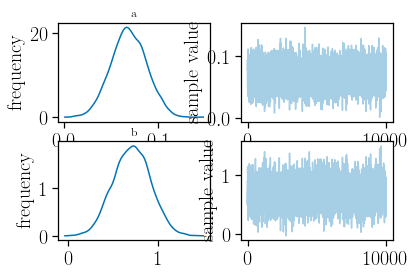

In [10]:
fit.plot()
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


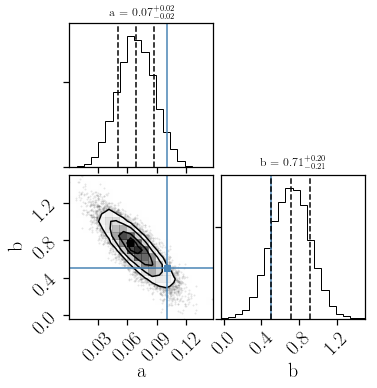

In [11]:
import corner
chains = np.array([fit['a'], fit['b']])
corner.corner(chains.T, labels=['a','b'], truths=[a, b],
              quantiles=[0.159, 0.50, 0.841],show_titles=True)
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


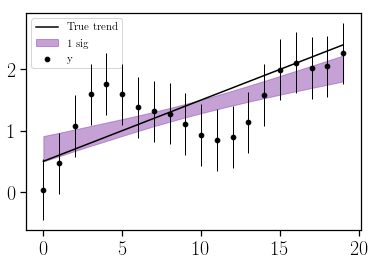

In [12]:
A = np.vander(x, 2)
lines = np.dot(chains.T, A.T)
quantiles = np.percentile(lines, [16, 84], axis=0)
plt.fill_between(x, quantiles[0], quantiles[1], color="#8d44ad", alpha=.5, label='1 sig')
plt.errorbar(x, y, yerr=np.ones_like(y)*theta[0], fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
plt.scatter(x, y, marker='o', s=22, c='k', zorder=1000, label='y')
plt.plot(x, trend, color='k', lw=1.5, label='True trend')
plt.legend()

Clearly, our 1 $\sigma$ region is not covering the true line

### With covariance matrix

In [13]:
import pystan
overwrite=True
cov_simple = '''
data {
    int<lower = 0> N;
    vector[N] y;
    vector[N] x;
    cov_matrix[N] Sigma;
}
parameters {
    real a;
    real b;
}
model {
    a ~ normal(0., 1.);
    b ~ normal(0., 1.);
    y ~ multi_normal(a*x + b, Sigma);
}
'''
import os
import pickle
model_path = 'cov_simple.pkl'
if overwrite:
    sm = pystan.StanModel(model_code = cov_simple)
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = cov_simple)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ea3aa063ddefa2b352f308cb882b2464 NOW.


In [14]:
dat = {'N':len(y),
      'y' : y,
      'x': x,
      'Sigma' : cov}
fit_2 = sm.sampling(data=dat, iter=10000, chains=2)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


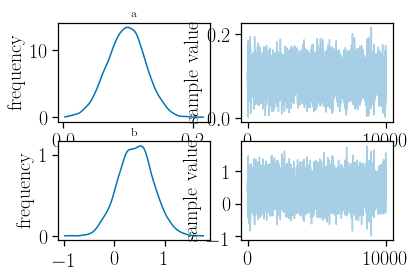

In [15]:
fit_2.plot()
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


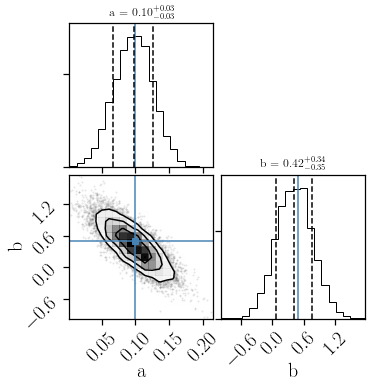

In [16]:
import corner
chains = np.array([fit_2['a'], fit_2['b']])
corner.corner(chains.T, labels=['a','b'], truths=[a, b],
              quantiles=[0.159, 0.50, 0.841],show_titles=True)
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


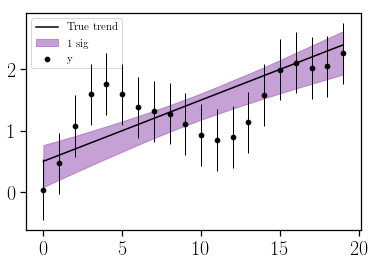

In [17]:
A = np.vander(x, 2)
lines = np.dot(chains.T, A.T)
quantiles = np.percentile(lines, [16, 84], axis=0)
plt.fill_between(x, quantiles[0], quantiles[1], color="#8d44ad", alpha=.5, label='1 sig')
plt.errorbar(x, y, yerr=np.ones_like(y)*theta[0], fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
plt.scatter(x, y, marker='o', s=22, c='k', zorder=1000, label='y')
plt.plot(x, trend, color='k', lw=1.5, label='True trend')
plt.legend()

### With faster covariance matrix

In [18]:
import pystan
overwrite=True
cov_fast = '''
functions {
    real precalc_multinormal_lpdf(vector y, vector y_true, real logdetc, matrix invc, int N, real Nfloat){
        vector[N] r;       
        r = y - y_true;

        return -0.5 * ((r' * invc * r) + logdetc + Nfloat * log(2*pi()));
    }
}
data {
    int<lower = 0> N;
    real Nfloat;
    vector[N] y;
    vector[N] x;
    matrix[N, N] invc;
    real logdetc;
}
parameters {
    real a;
    real b;
}
model {
    a ~ normal(0., 1.);
    b ~ normal(0., 1.);
    y ~ precalc_multinormal(a*x+b, logdetc, invc, N, Nfloat);
}
'''
import os
import pickle
model_path = 'cov_fast.pkl'
if overwrite:
    sm = pystan.StanModel(model_code = cov_fast)
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = cov_fast)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9389a85fdfbed42e79add87422df536d NOW.


In [19]:
dat = {'N':len(y),
       'Nfloat':np.float(len(y)),
       'y' : y,
       'x':x,
      'invc': np.linalg.inv(cov),
      'logdetc':np.linalg.det(cov)}
fit_3 = sm.sampling(data=dat, iter=10000, chains=2)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


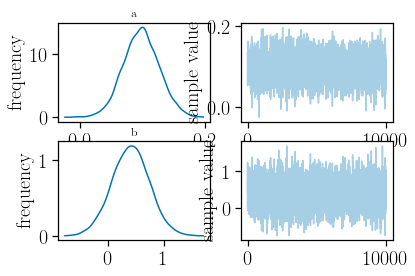

In [20]:
fit_3.plot()
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


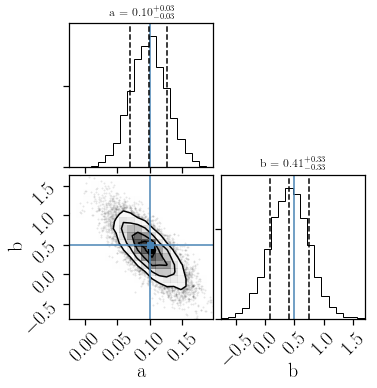

In [21]:
import corner
chains = np.array([fit_3['a'], fit_3['b']])
corner.corner(chains.T, labels=['a','b'], truths=[a, b],
              quantiles=[0.159, 0.50, 0.841],show_titles=True)
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


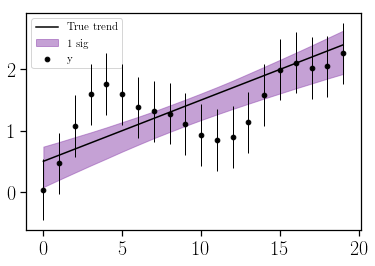

In [22]:
A = np.vander(x, 2)
lines = np.dot(chains.T, A.T)
quantiles = np.percentile(lines, [16, 84], axis=0)
plt.fill_between(x, quantiles[0], quantiles[1], color="#8d44ad", alpha=.5, label='1 sig')
plt.errorbar(x, y, yerr=np.ones_like(y)*theta[0], fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
plt.scatter(x, y, marker='o', s=22, c='k', zorder=1000, label='y')
plt.plot(x, trend, color='k', lw=1.5, label='True trend')
plt.legend()